In [10]:
import torch
import functions_data
import os 
import functions_ordinal
import matplotlib.pyplot as plt 
from torch import optim
import tqdm
import functions_plotting
import pandas as pd 
import numpy as np
import seaborn as sns 

##  Import three exams that the ordinal model was trained on 

In [11]:
data_path = os.path.join(os.getcwd(), 'data', 'three_exams_cleaned.csv')
dict_path = os.path.join(os.getcwd(), 'data', 'questions_info_dict.p')
data, questions_info = functions_data.load_data_and_dictionary(data_path, dict_path)

# if the score is higher than max score for the given question, put score = max_score 
for col in data:
    m = questions_info[col]['Max']
    data[col].loc[data[col] > m] = m

# rename keys in the questions_info 
new_dictionary = {}
columns_mapper = {}
dict_keys = questions_info.keys()
for ind, key_old in enumerate(dict_keys):
    key_new = 'q' + str(ind + 1)
    new_dictionary[key_new] = questions_info[key_old]
    columns_mapper[key_old] = key_new 

# rename column in the dataframe
data = data.rename(columns=columns_mapper)

In [12]:
# convert pandas dataframe to tensor 
data_tensor = torch.tensor(data.values)

# separate train, test and validation data 
train_data, validation_data, test_data = functions_ordinal.custom_separate_train_validation_test_data(data_tensor, train_fraction=0.7)

n_students, n_questions = data_tensor.shape[0], data_tensor.shape[1]
max_score = int(data_tensor.max().numpy())

In [13]:
print(train_data.shape)
print(test_data.shape)
print(validation_data.shape)

torch.Size([949423, 3])
torch.Size([135632, 3])
torch.Size([135632, 3])


## Import trained parameters for predicting the data

In [14]:
bs = torch.load(os.path.join(os.getcwd(), 'params', '3EXAMS_bs_trained_4000iter.pth'))
bq0 = torch.load(os.path.join(os.getcwd(), 'params', '3EXAMS_bq0_trained_4000iter.pth'))
rho = torch.load(os.path.join(os.getcwd(), 'params', '3EXAMS_rho_trained_4000iter.pth'))

In [15]:
test_data_max_scores = functions_ordinal.generate_max_scores_tensor(test_data, new_dictionary)
train_data_max_scores = functions_ordinal.generate_max_scores_tensor(train_data, new_dictionary)
validation_data_max_scores = functions_ordinal.generate_max_scores_tensor(validation_data, new_dictionary)

# Confusion matrix with marginal distributions

In [16]:
prob_matrix = functions_ordinal.generate_prob_matrix(test_data, bs, bq0, rho, max_score, test_data_max_scores)

predicted_scores_thresholding = prob_matrix.argmax(axis = 1)
predicted_scores = predicted_scores_thresholding


# predicted_scores = functions_ordinal.predict_scores(test_data, bs_trained, bq0_trained, rho_trained, max_score, test_data_max_scores)
true_scores = test_data[:, 2]

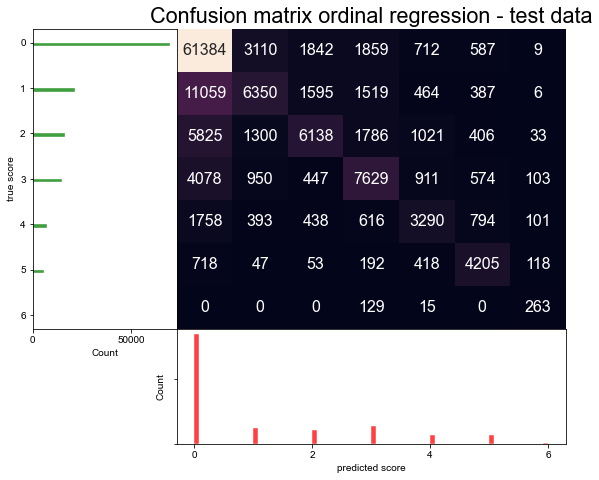

In [17]:
functions_plotting.confusion_matrix_with_marginals(true_scores = true_scores, predicted_scores=predicted_scores, title = 'Confusion matrix ordinal regression - test data')

# Test errors and accuracies separated 

In [18]:
# Calculate mean squared error 
loss = torch.nn.MSELoss()
MSE = loss(true_scores, predicted_scores)
print('Mean squared error on data ', np.sqrt(MSE))

# Calculate mean absolute error 
print('Mean absolute error ', abs(true_scores - predicted_scores).mean())

# mean score on the test data
print('Mean score on the true data ', true_scores.mean())

Mean squared error on data  tensor(1.2722, dtype=torch.float64)
Mean absolute error  tensor(0.6482, dtype=torch.float64)
Mean score on the true data  tensor(1.1740, dtype=torch.float64)


### Separate MSE 


In [19]:
k_max = 5
accuracies_train = []
MAEs_train = []
MSEs_train = []
acc_points_train = []
means_train = []

dataframe = pd.DataFrame(test_data).astype("float")
dataframe = dataframe.rename(columns={0: "studentID", 1: "questionID", 2: "score"})
dataframe['max_scores'] = test_data_max_scores
for q in range(1,n_questions):
    # filter question q
    df = dataframe.loc[dataframe['questionID'] == q]
    df_ = torch.Tensor(df[['studentID', 'questionID', 'score']].values)
    df_max_scores = torch.Tensor(df['max_scores'].values)
    predicted_scores_thresholding = prob_matrix.argmax(axis = 1)
    predicted_scores = predicted_scores_thresholding

    predicted_scores = functions_ordinal.predict_scores(df_, bs, bq0, rho, max_score, df_max_scores)
    true_scores = df_[:, 2]

    acc = (true_scores == predicted_scores).int().sum()/true_scores.shape[0]

    # Calculate mean squared error 
    loss = torch.nn.MSELoss()
    MSE = loss(true_scores, predicted_scores)

    # Calculate mean absolute error 
    MAE = abs(true_scores - predicted_scores).mean()

    #up-to-a-point-accuracy 
    diff = abs(true_scores - predicted_scores)
    diff = [1 if d <= 1 else 0 for d in diff]
    acc_point = sum(diff)/true_scores.shape[0]

    mean = true_scores.mean()
    
    accuracies_train.append(acc)
    MSEs_train.append(MSE) 
    MAEs_train.append(MAE) 
    acc_points_train.append(acc_point)
    means_train.append(mean)


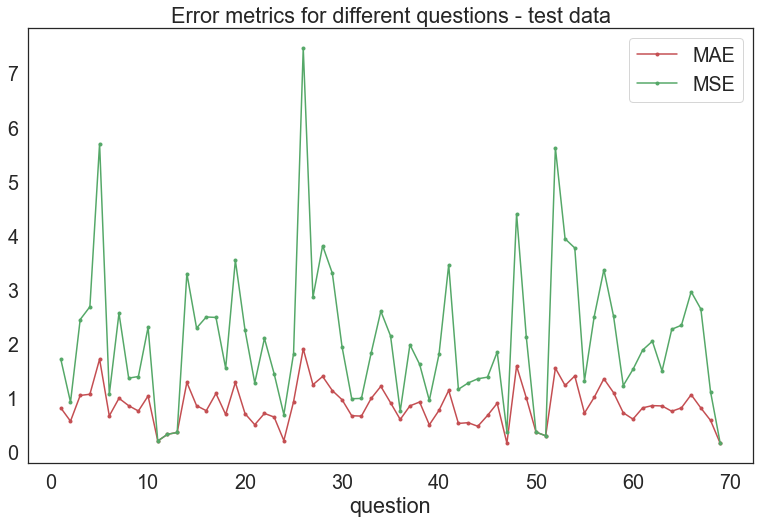

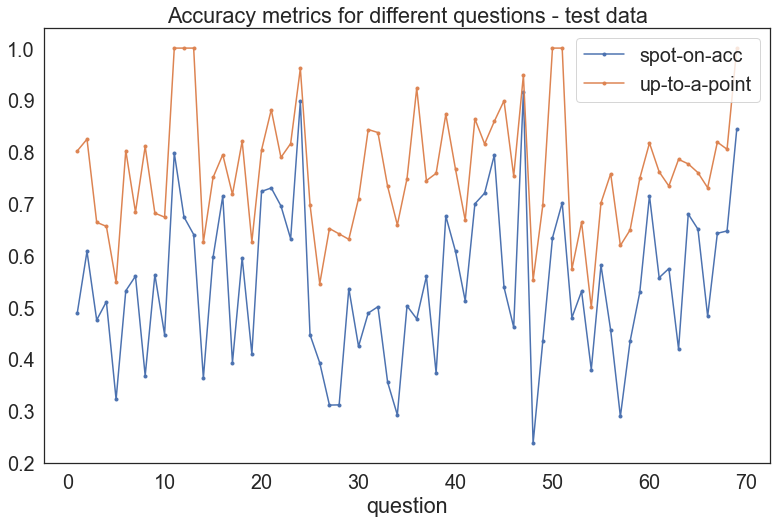

In [20]:
# Plot error and accuracies metrics on data
sns.set_style('white')
questions = np.arange(1,n_questions)
plt.figure(figsize=(13,8))
plt.plot(questions, MAEs_train, marker = '.', label ='MAE', color='r')
plt.plot(questions, MSEs_train, marker = '.', label = 'MSE', color = 'g')
plt.legend()
plt.title('Error metrics for different questions - test data')
plt.xlabel('question')
plt.show()

questions = np.arange(1,n_questions)
plt.figure(figsize=(13,8))
plt.plot(questions, accuracies_train, marker = '.', label ='spot-on-acc')
plt.plot(questions, acc_points_train, marker = '.', label = 'up-to-a-point')
plt.legend()
plt.title('Accuracy metrics for different questions - test data')
plt.xlabel('question')
plt.show()



## Confusion matrices for different questions 
Save the confusion matrix for question in the designated folder 

In [ ]:
# Confusion matrices for different questions 

for q in range(1,25):

    dataframe = pd.DataFrame(test_data).astype("float")
    dataframe = dataframe.rename(columns={0: "studentID", 1: "questionID", 2: "score"})

    # test_dataframe_max_score1 = test_dataframe.loc[test_dataframe['questionID'] in set_q_keep]
    # test dataframe modified has questions on which the maximum score was k 
    dataframe = dataframe.loc[dataframe['questionID'] == q]
    dataframe = torch.Tensor(dataframe.values)

    predicted_scores = ordinal_functions.predict_scores(dataframe, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    true_scores = dataframe[:, 2]


    conf_matrix = confusion_matrix(true_scores.int(), predicted_scores.int())
    lower_bound = true_scores.min().int()
    upper_bound = true_scores.max().int()
    df_cm = pd.DataFrame(conf_matrix, range(upper_bound + 1), range(upper_bound + 1))
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size fmt = 'g' to do with unscaled option
    plt.title('Confusion matrix for the ordinal regression for question ' + str(q))
    plt.xlabel('predicted score')
    plt.ylabel('true score')
    path = 'C:/Users/Anastasija/Desktop/FYP Personalised Education/ordinal figures/question' + str(q) + '.png'
    plt.savefig(path)

    

In [ ]:
# Error plots 
scores = np.arange(1,6)
plt.plot(scores, MAEs, marker='.', label='MAE')
plt.plot(scores, MSEs, marker='.', label='MSE')
plt.plot(scores, means, marker = '*', label = 'mean score')
plt.legend()
plt.xlabel('Maximum score on question')
plt.title('Errors separated on test set')

In [ ]:
scores = np.arange(1,6)
plt.plot(scores, accuracies, marker='.', label = 'acc')
plt.plot(scores, acc_points, marker = '.', label = 'acc-up-to-point')
plt.legend()
plt.xlabel('Maximum score on question')
plt.title('Accuracies separated on test set')

print(scores)

## Experiment 1: Filter questions for which the maximum score was 3 

In [ ]:
csv_path = 'C:/Users/Anastasija/Desktop/FYP Personalised Education/data/all_exams_raw.csv'
ordinal_data, questions_info = import_first_exam(csv_path)

for col in ordinal_data:
    m = questions_info[col]['Max']
    ordinal_data[col].loc[ordinal_data[col] > m] = m


n_students = ordinal_data.shape[0]
n_questions = ordinal_data.shape[1]


In [ ]:
questions_to_eliminate = []
questions = questions_info.keys()
for q in questions_info.keys():
    if questions_info[q]['Max'] > 3:
        questions_to_eliminate.append(q)
print(questions_to_eliminate)
ordinal_data_filtered_q = ordinal_data.drop(questions_to_eliminate, axis=1)

In [ ]:
ordinal_data = ordinal_data_filtered_q 

n_students = ordinal_data.shape[0] # 38224
n_questions = ordinal_data.shape[1] # 11 

max_score = 3 
ordinal_data = convert_df_to_tensor(ordinal_data)
train_data, validation_data, test_data = ordinal_functions.separate_train_validation_test_data(ordinal_data)

In [ ]:
print(train_data)

In [ ]:
sns.distplot(ordinal_data)
plt.title('Ordinal data distribution for questions with maximum score 3')
plt.show()

## Train parameters just for questions that are out of 3 

In [ ]:
torch.manual_seed(100)

# initialization of parameters 
bs_generator_prediction = torch.randn(n_students, requires_grad=True)
bq0_generator_prediction = torch.distributions.uniform.Uniform(0,1).sample([n_questions,])
rho_generator_prediction = torch.normal(0, 0.1, size = (n_questions, max_score), requires_grad=True) # rho1, rho2, rho3 

bq0_generator_prediction.requires_grad = True  


nlls_train = []
nlls_validation = []
nlls_test = []

In [ ]:
print(bq0_generator_prediction.shape)
print(rho_generator_prediction.shape)
print(bs_generator_prediction.shape)

In [ ]:
predicted_scores_pre_training = ordinal_functions.predict_scores(bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score, n_students, n_questions)

In [ ]:
predicted_scores_pre_training = ordinal_functions.predict_scores(bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score, n_students, n_questions)

predicted_scores = predicted_scores_pre_training.reshape(-1)

student_id = torch.arange(1, n_students + 1)
student_id = student_id.repeat_interleave(n_questions)

question_id = torch.arange(1, n_questions + 1)
question_id = question_id.repeat(n_students)

data = torch.zeros([n_students*n_questions, 3])
data = torch.stack((student_id, question_id, predicted_scores), dim=1)

torch.manual_seed(0)
data = data[torch.randperm(data.size()[0])]

n_train = int(data.shape[0]*0.7)
n_validation = int(data.shape[0]*0.2)
n_test = data.shape[0]-(n_train + n_validation)

train_data_predictions = data[:n_train, :]
validation_data_predictions = data[n_train:n_train+n_validation, :]
test_data_predictions = data[n_train+n_validation:, :]

train_prediction_scores = train_data_predictions[:, 2].int()
train_true_scores = train_data[:, 2].int()

dim = 10
pred_mat = train_prediction_scores[10000:10000+dim*dim].reshape((dim,dim))
true_mat = train_true_scores[10000:10000+dim*dim].reshape((dim, dim))

print(pred_mat)
print(true_mat)

_min, _max = 0, max_score
plt.matshow(pred_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Predicted scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()
plt.matshow(true_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('True scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()

diff_mat = torch.abs(pred_mat - true_mat).float()

plt.matshow(diff_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Absolute error matrix')
plt.colorbar()
plt.grid(b=None)
plt.show()


In [ ]:
iterations = 60000
learning_rate = 0.0001


for iter in range(iterations):

    nll_train = ordinal_functions.calculate_nll(train_data, bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score)
     
    nll_train.backward()

    
    with torch.no_grad():

        bs_generator_prediction -= learning_rate*bs_generator_prediction.grad
        bq0_generator_prediction-= learning_rate*bq0_generator_prediction.grad
        rho_generator_prediction -= learning_rate*rho_generator_prediction.grad

        # Manually zero the gradients after updating weights
        bs_generator_prediction.grad = None
        bq0_generator_prediction.grad = None
        rho_generator_prediction.grad = None


    if iter % 10 == 0:


        nlls_train.append(nll_train)

        nll_test = ordinal_functions.calculate_nll(test_data, bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score)
        nlls_test.append(nll_test)

        nll_validation = ordinal_functions.calculate_nll(validation_data, bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score)
        nlls_validation.append(nll_validation)
    
    if iter % 1000 == 0: 
        print(iter, nll_train)
        bs_save = bs_generator_prediction
        bq0_save = bq0_generator_prediction
        rho_save = rho_generator_prediction

        save_loc='C:\\Users\\Anastasija\\Desktop\\FYP Personalised Education\\code\\checkpoints_questions_max_3_score/'
        bs_save_loc = save_loc + str(iter) + '__checkpoint_bs.pth'
        bq0_save_loc = save_loc + str(iter) + '__checkpoint_bq0.pth'
        rho_save_loc = save_loc + str(iter) + '__checkpoint_rho.pth'

        torch.save(bs_save, bs_save_loc)
        torch.save(bq0_save, bq0_save_loc)
        torch.save(rho_save, rho_save_loc)


## Load trained parameters and compare results 

In [ ]:
iters = np.arange(0, 16000, 1000)

true_scores_all_data = ordinal_data 
true_scores_train  = train_data[:, 2]


nlls_train = []
nlls_test = []
nlls_validation = []
accuracies = []

In [ ]:
for iter in iters:
    save_loc='C:\\Users\\Anastasija\\Desktop\\FYP Personalised Education\\code\\checkpoints_questions_max_3_score/'
    bs_save_loc = save_loc + str(iter) + '__checkpoint_bs.pth'
    bq0_save_loc = save_loc + str(iter) + '__checkpoint_bq0.pth'
    rho_save_loc = save_loc + str(iter) + '__checkpoint_rho.pth'


    bs_trained_params = torch.load(bs_save_loc)
    bq0_trained_params = torch.load(bq0_save_loc)
    rho_trained_params = torch.load(rho_save_loc)

    nll_train = ordinal_functions.calculate_nll(train_data, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    nlls_train.append(nll_train)

    nll_test = ordinal_functions.calculate_nll(test_data, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    nlls_test.append(nll_test)

    nll_validation = ordinal_functions.calculate_nll(validation_data, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    nlls_validation.append(nll_validation)

    predicted_scores_all_data = ordinal_functions.predict_scores(bs_trained_params, bq0_trained_params, rho_trained_params, max_score, n_students, n_questions)
    train_prediction, _, _ = ordinal_functions.separate_train_validation_test_data(predicted_scores_all_data)
    predicted_scores_train = train_prediction[:, 2]
    accuracy_train_data = ordinal_functions.full_accuracy(predicted_scores_train, true_scores_train)
    accuracies.append(accuracy_train_data)

In [ ]:
plt.plot(accuracies)
plt.ylabel('Accuracy on test set')
plt.xlabel('epoch (1000 iterations)')
plt.title('Accuracy on test set for questions - max score 3 or less')
plt.show()

In [ ]:
# plt.plot(nlls)

# nlls_test = torch.tensor(nlls_test)
plt.plot(torch.tensor(nlls_train)/train_data.shape[0], label = 'train nll')
plt.plot(torch.tensor(nlls_test)/test_data.shape[0], label = 'test nll')
plt.plot(torch.tensor(nlls_validation)/validation_data.shape[0], label = 'validation nll')
# plt.plot(nlls_test/test_data.shape[0], label ='test')
plt.xlabel('epoch (1000 iterations)')
plt.ylabel('Negative log-likelihood')
plt.legend()


plt.show()

In [ ]:
train_prediction, _, _ = ordinal_functions.separate_train_validation_test_data(predicted_scores_all_data)
true_scores_train  = train_data[:, 2]
predicted_scores_train = train_prediction[:, 2]

accuracy_train_data = ordinal_functions.full_accuracy(predicted_scores_train, true_scores_train)
accuracy_all_data = ordinal_functions.full_accuracy(predicted_scores_all_data.flatten(), true_scores_all_data.flatten())


In [ ]:
print(accuracy_train_data)
print(accuracy_all_data)

In [ ]:
# Confusion matrix 

predicted_scores = predicted_scores_train
true_scores = true_scores_train
conf_matrix = confusion_matrix(true_scores.int(), predicted_scores.int())
df_cm = pd.DataFrame(conf_matrix, range(4), range(4))
plt.figure(figsize=(13,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size fmt = 'g' to do with unscaled option
plt.title('Confusion matrix for easy questions')
plt.xlabel('predicted score')
plt.ylabel('true score')
plt.show()

In [ ]:
predicted_scores_pre_training = ordinal_functions.predict_scores(bs_trained_params, bq0_trained_params, rho_trained_params, max_score, n_students, n_questions)

predicted_scores = predicted_scores_pre_training.reshape(-1)

student_id = torch.arange(1, n_students + 1)
student_id = student_id.repeat_interleave(n_questions)

question_id = torch.arange(1, n_questions + 1)
question_id = question_id.repeat(n_students)

data = torch.zeros([n_students*n_questions, 3])
data = torch.stack((student_id, question_id, predicted_scores), dim=1)

torch.manual_seed(0)
data = data[torch.randperm(data.size()[0])]

n_train = int(data.shape[0]*0.7)
n_validation = int(data.shape[0]*0.2)
n_test = data.shape[0]-(n_train + n_validation)

train_data_predictions = data[:n_train, :]
validation_data_predictions = data[n_train:n_train+n_validation, :]
test_data_predictions = data[n_train+n_validation:, :]

train_prediction_scores = train_data_predictions[:, 2].int()
train_true_scores = train_data[:, 2].int()

dim = 15
pred_mat = train_prediction_scores[10000:10000+dim*dim].reshape((dim,dim))
true_mat = train_true_scores[10000:10000+dim*dim].reshape((dim, dim))


_min, _max = 0, max_score
plt.matshow(pred_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Predicted scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()
plt.matshow(true_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('True scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()

diff_mat = torch.abs(pred_mat - true_mat).float()

plt.matshow(diff_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Absolute error matrix')
plt.colorbar()
plt.grid(b=None)
plt.show()


## Experiment 2: Filter easy questions based on meta data

In [ ]:
# load all data
csv_path = 'C:/Users/Anastasija/Desktop/FYP Personalised Education/data/all_exams_raw.csv'
ordinal_data, questions_info = import_first_exam(csv_path)

for col in ordinal_data:
    m = questions_info[col]['Max']
    ordinal_data[col].loc[ordinal_data[col] > m] = m


n_students = ordinal_data.shape[0]
n_questions = ordinal_data.shape[1]


In [ ]:
questions_to_eliminate = []
questions = questions_info.keys()
for q in questions_info.keys():
    if int(questions_info[q]['Difficulty']) > 1:
        questions_to_eliminate.append(q)
print(questions_to_eliminate)
ordinal_data_filtered_q = ordinal_data.drop(questions_to_eliminate, axis=1)

In [ ]:
ordinal_data = ordinal_data_filtered_q 

n_students = ordinal_data.shape[0] # 38224
n_questions = ordinal_data.shape[1] # 14

ordinal_data = convert_df_to_tensor(ordinal_data)
train_data, validation_data, test_data = ordinal_functions.separate_train_validation_test_data(ordinal_data)

max_score = int(ordinal_data.max())

In [ ]:
sns.distplot(ordinal_data)
plt.title('Ordinal data distribution for questions with maximum score 3')
plt.show()

### Train parameters for the model for easy questions (difficulty = 1)

In [ ]:
torch.manual_seed(100)

# initialization of parameters 
bs_generator_prediction = torch.randn(n_students, requires_grad=True)
bq0_generator_prediction = torch.distributions.uniform.Uniform(0,1).sample([n_questions,])
rho_generator_prediction = torch.normal(0, 0.1, size = (n_questions, max_score), requires_grad=True) # rho1, rho2, rho3 

bq0_generator_prediction.requires_grad = True  


nlls_train = []
nlls_validation = []
nlls_test = []



In [ ]:
predicted_scores_pre_training = ordinal_functions.predict_scores(bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score, n_students, n_questions)

In [ ]:
predicted_scores_pre_training = ordinal_functions.predict_scores(bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score, n_students, n_questions)

predicted_scores = predicted_scores_pre_training.reshape(-1)

student_id = torch.arange(1, n_students + 1)
student_id = student_id.repeat_interleave(n_questions)

question_id = torch.arange(1, n_questions + 1)
question_id = question_id.repeat(n_students)

data = torch.zeros([n_students*n_questions, 3])
data = torch.stack((student_id, question_id, predicted_scores), dim=1)

torch.manual_seed(0)
data = data[torch.randperm(data.size()[0])]

n_train = int(data.shape[0]*0.7)
n_validation = int(data.shape[0]*0.2)
n_test = data.shape[0]-(n_train + n_validation)

train_data_predictions = data[:n_train, :]
validation_data_predictions = data[n_train:n_train+n_validation, :]
test_data_predictions = data[n_train+n_validation:, :]

train_prediction_scores = train_data_predictions[:, 2].int()
train_true_scores = train_data[:, 2].int()

dim = 10
pred_mat = train_prediction_scores[10000:10000+dim*dim].reshape((dim,dim))
true_mat = train_true_scores[10000:10000+dim*dim].reshape((dim, dim))


_min, _max = 0, max_score
plt.matshow(pred_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Predicted scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()
plt.matshow(true_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('True scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()

diff_mat = torch.abs(pred_mat - true_mat).float()

plt.matshow(diff_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Absolute error matrix')
plt.colorbar()
plt.grid(b=None)
plt.show()


In [ ]:
predicted_scores_all_data = ordinal_functions.predict_scores(bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score, n_students, n_questions)
train_prediction, _, _ = ordinal_functions.separate_train_validation_test_data(predicted_scores_all_data)
predicted_scores_train = train_prediction[:, 2]
true_scores_train = train_data[:, 2]

accuracy_train_data = ordinal_functions.full_accuracy(predicted_scores_train, true_scores_train)
print('Accuracy pre training on train data ' + str(accuracy_train_data))

In [ ]:
iterations = 60000
learning_rate = 0.0001


for iter in range(iterations):

    nll_train = ordinal_functions.calculate_nll(train_data, bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score)
     
    nll_train.backward()

    
    with torch.no_grad():

        bs_generator_prediction -= learning_rate*bs_generator_prediction.grad
        bq0_generator_prediction-= learning_rate*bq0_generator_prediction.grad
        rho_generator_prediction -= learning_rate*rho_generator_prediction.grad

        # Manually zero the gradients after updating weights
        bs_generator_prediction.grad = None
        bq0_generator_prediction.grad = None
        rho_generator_prediction.grad = None


    if iter % 10 == 0:
        nlls_train.append(nll_train)

        nll_test = ordinal_functions.calculate_nll(test_data, bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score)
        nlls_test.append(nll_test)

        nll_validation = ordinal_functions.calculate_nll(validation_data, bs_generator_prediction, bq0_generator_prediction, rho_generator_prediction, max_score)
        nlls_validation.append(nll_validation)
    
    if iter % 100 == 0: 
        print(iter, nll_train)
        bs_save = bs_generator_prediction
        bq0_save = bq0_generator_prediction
        rho_save = rho_generator_prediction

        save_loc='C:\\Users\\Anastasija\\Desktop\\FYP Personalised Education\\code\\checkpoints_exp2/'
        bs_save_loc = save_loc + str(iter) + '__checkpoint_bs.pth'
        bq0_save_loc = save_loc + str(iter) + '__checkpoint_bq0.pth'
        rho_save_loc = save_loc + str(iter) + '__checkpoint_rho.pth'

        torch.save(bs_save, bs_save_loc)
        torch.save(bq0_save, bq0_save_loc)
        torch.save(rho_save, rho_save_loc)


## Use trained parameters to do prediction 

In [ ]:
iters = np.arange(0, 8100, 100)

true_scores_all_data = ordinal_data 
true_scores_train  = train_data[:, 2]


nlls_train = []
nlls_test = []
nlls_validation = []
accuracies = []

In [ ]:
for iter in iters:
    save_loc='C:\\Users\\Anastasija\\Desktop\\FYP Personalised Education\\code\\checkpoints_exp2/'
    bs_save_loc = save_loc + str(iter) + '__checkpoint_bs.pth'
    bq0_save_loc = save_loc + str(iter) + '__checkpoint_bq0.pth'
    rho_save_loc = save_loc + str(iter) + '__checkpoint_rho.pth'


    bs_trained_params = torch.load(bs_save_loc)
    bq0_trained_params = torch.load(bq0_save_loc)
    rho_trained_params = torch.load(rho_save_loc)

    nll_train = ordinal_functions.calculate_nll(train_data, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    nlls_train.append(nll_train)

    nll_test = ordinal_functions.calculate_nll(test_data, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    nlls_test.append(nll_test)

    nll_validation = ordinal_functions.calculate_nll(validation_data, bs_trained_params, bq0_trained_params, rho_trained_params, max_score)
    nlls_validation.append(nll_validation)

    predicted_scores_all_data = ordinal_functions.predict_scores(bs_trained_params, bq0_trained_params, rho_trained_params, max_score, n_students, n_questions)
    train_prediction, _, _ = ordinal_functions.separate_train_validation_test_data(predicted_scores_all_data)
    predicted_scores_train = train_prediction[:, 2]
    accuracy_train_data = ordinal_functions.full_accuracy(predicted_scores_train, true_scores_train)
    accuracies.append(accuracy_train_data)

In [ ]:
plt.plot(accuracies)
plt.ylabel('Accuracy on test set')
plt.xlabel('epoch (1000 iterations)')
plt.title('Accuracy on test set for questions - max score 3 or less')
plt.show()

In [ ]:
print(accuracies[-1])

In [ ]:
# plt.plot(nlls)

# nlls_test = torch.tensor(nlls_test)
plt.plot(torch.tensor(nlls_train)/train_data.shape[0], label = 'train nll')
plt.plot(torch.tensor(nlls_test)/test_data.shape[0], label = 'test nll')
plt.plot(torch.tensor(nlls_validation)/validation_data.shape[0], label = 'validation nll')
# plt.plot(nlls_test/test_data.shape[0], label ='test')
plt.xlabel('epoch (1000 iterations)')
plt.ylabel('Negative log-likelihood')
plt.legend()


plt.show()

In [ ]:
train_prediction, _, _ = ordinal_functions.separate_train_validation_test_data(predicted_scores_all_data)
true_scores_train  = train_data[:, 2]
predicted_scores_train = train_prediction[:, 2]

accuracy_train_data = ordinal_functions.full_accuracy(predicted_scores_train, true_scores_train)
accuracy_all_data = ordinal_functions.full_accuracy(predicted_scores_all_data.flatten(), true_scores_all_data.flatten())

print(accuracy_train_data)

In [ ]:
predicted_scores_pre_training = ordinal_functions.predict_scores(bs_trained_params, bq0_trained_params, rho_trained_params, max_score, n_students, n_questions)

predicted_scores = predicted_scores_pre_training.reshape(-1)

student_id = torch.arange(1, n_students + 1)
student_id = student_id.repeat_interleave(n_questions)

question_id = torch.arange(1, n_questions + 1)
question_id = question_id.repeat(n_students)

data = torch.zeros([n_students*n_questions, 3])
data = torch.stack((student_id, question_id, predicted_scores), dim=1)

torch.manual_seed(0)
data = data[torch.randperm(data.size()[0])]

n_train = int(data.shape[0]*0.7)
n_validation = int(data.shape[0]*0.2)
n_test = data.shape[0]-(n_train + n_validation)

train_data_predictions = data[:n_train, :]
validation_data_predictions = data[n_train:n_train+n_validation, :]
test_data_predictions = data[n_train+n_validation:, :]

train_prediction_scores = train_data_predictions[:, 2].int()
train_true_scores = train_data[:, 2].int()

dim = 15
pred_mat = train_prediction_scores[10000:10000+dim*dim].reshape((dim,dim))
true_mat = train_true_scores[10000:10000+dim*dim].reshape((dim, dim))


_min, _max = 0, max_score
plt.matshow(pred_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Predicted scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()
plt.matshow(true_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('True scores in the test set')
plt.colorbar()
plt.grid(b=None)
plt.show()

diff_mat = torch.abs(pred_mat - true_mat).float()

plt.matshow(diff_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
plt.title('Absolute error matrix')
plt.colorbar()
plt.grid(b=None)
plt.show()


In [ ]:
# Confusion matrix 

predicted_scores = predicted_scores_train
true_scores = true_scores_train
conf_matrix = confusion_matrix(true_scores.int(), predicted_scores.int())
df_cm = pd.DataFrame(conf_matrix, range(6), range(6))
plt.figure(figsize=(13,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size fmt = 'g' to do with unscaled option
plt.title('Confusion matrix for easy questions')
plt.xlabel('predicted score')
plt.ylabel('true score')
plt.show()